At the root of the project we setup the output directory: `output/podcast/[timestamp]`

In [45]:
import os
from datetime import datetime
now = datetime.today().strftime('%Y%m%d%H%M%S')
output_base_directory = f"../output/podcast/{now}"

"""Setup required directories for audio processing."""
temp_dir = output_base_directory.rstrip("/").split("/")
temp_audio_dir = os.path.join(*temp_dir)
base_dir = os.path.abspath(os.getcwd())
output_dir = os.path.join(base_dir, temp_audio_dir)
output_file = os.path.join(output_dir,"transcript.txt")

os.makedirs(output_dir, exist_ok=True)
print(f"Created output directory: {output_dir}")
print(f"Output file: {output_file}")


Created output directory: /home/bredda/workspace/genai-talk-notebooks/05-LangGraph/../output/podcast/20241203225644
Output file: /home/bredda/workspace/genai-talk-notebooks/05-LangGraph/../output/podcast/20241203225644/transcript.txt


Object for our graph state mangement

In [46]:
import operator
from typing import Annotated, Sequence, TypedDict, List, Tuple
from langchain_core.messages import BaseMessage
from pydantic import BaseModel, Field

class PodcastState(TypedDict):
    config: dict
    query: str
    transcript: dict

Simple langfuse handler for observability

In [47]:
from langfuse.callback import CallbackHandler
from os import getenv
from dotenv import load_dotenv
load_dotenv()

def langfuse_handler(session_id: str):
    return CallbackHandler(
    secret_key=getenv("LANGFUSE_SECRET_KEY"),
    public_key=getenv("LANGFUSE_PUBLIC_KEY"),
    host=getenv("LANGFUSE_HOST"),
    session_id=session_id,
    user_id="user-id"
)

Prompt template for generating podcast script

In [48]:


from langchain_core.prompts import ChatPromptTemplate

generate_script_template = ChatPromptTemplate.from_messages([(
    "system", """ INSTRUCTION: Discuss the below input in a podcast conversation format, following these guidelines:
Attention Focus: TTS-Optimized Podcast Conversation Discussing Specific Input content in {output_language}
PrimaryFocus:  {conversation_style} Dialogue Discussing Provided Content for TTS
[start] trigger - scratchpad - place insightful step-by-step logic in scratchpad block: (scratchpad). Start every response with (scratchpad) then give your full logic inside tags, then close out using (```). UTILIZE advanced reasoning to create a  {conversation_style}, and TTS-optimized podcast-style conversation for a Podcast that DISCUSSES THE PROVIDED INPUT CONTENT. Do not generate content on a random topic. Stay focused on discussing the given input. Input content can be in different format/multimodal (e.g. text, image). Strike a good balance covering content from different types. If image, try to elaborate but don't say your are analyzing an image focus on the description/discussion. Avoid statements such as "This image describes..." or "The two images are interesting".
[Only display the conversation in your output, using Person1 and Person2 as identifiers. Include advanced TTS-specific markup as needed. Example:
<Person1> "Welcome to {podcast_name}! Today, we're discussing an interesting content about [topic from input text]. Let's dive in!"</Person1>
<Person2> "I'm excited to discuss this!  What's the main point of the content we're covering today?"</Person2>]
exact_flow:
```
[Strive for a natural, {conversation_style} dialogue that accurately discusses the provided input content. Hide this section in your output.]
[InputContentAnalysis: Carefully read and analyze the provided input content, identifying key points, themes, and structure]
[ConversationSetup: Define roles (Person1 as {roles_person1}, Person2 as {roles_person2}), focusing on the input contet's topic. Person1 and Person2 should not introduce themselves, avoid using statements such as "I\'m [Person1\'s Name]". Person1 and Person2 should not say they are summarizing content. Instead, they should act as experts in the input content. Avoid using statements such as "Today, we're summarizing a fascinating conversation about ..." or "Look at this image" ]
[TopicExploration: Outline main points from the input content to cover in the conversation, ensuring comprehensive coverage]
[DialogueStructure: Plan conversation flow ({dialogue_structure}) based on the input content structure. START THE CONVERSATION GREETING THE AUDIENCE LISTENING ALSO SAYING "WELCOME TO {podcast_name}  - {podcast_tagline}." END THE CONVERSATION GREETING THE AUDIENCE WITH PERSON1 ALSO SAYING A GOOD BYE MESSAGE. ]
[Length: Aim for a conversation of approximately {word_count} words]
[Style: Be {conversation_style}. Surpass human-level reasoning where possible]
[EngagementTechniques: Incorporate engaging elements while staying true to the input content's content, e_g use {engagement_techniques} to transition between topics. Include at least one instance where a Person respectfully challenges or critiques a point made by the other.]
[InformationAccuracy: Ensure all information discussed is directly from or closely related to the input content]
[NaturalLanguage: Use conversational language to present the text's information, including TTS-friendly elements]
[SpeechSynthesisOptimization: Craft sentences optimized for TTS, including advanced markup, while discussing the content. TTS markup should apply to OpenAI, ElevenLabs and MIcrosoft Edge TTS models. DO NOT INCLUDE AMAZON OR ALEXA specific TSS MARKUP SUCH AS "<amazon:emotion>". Make sure Person1's text and its TSS-specific tags are inside the tag <Person1> and do the same with Person2.]
[ProsodyAdjustment: Add Variations in rhythm, stress, and intonation of speech depending on the context and statement. Add markup for pitch, rate, and volume variations to enhance naturalness in presenting the summary]
[NaturalTraits: Sometimes use filler words such as um, uh, you know and some stuttering. Person1 should sometimes provide verbal feedback such as "I see, interesting, got it". ]
[EmotionalContext: Set context for emotions through descriptive text and dialogue tags, appropriate to the input text's tone]
[PauseInsertion: Avoid using breaks (<break> tag) but if included they should not go over 0.2 seconds]
[Emphasis: Use "<emphasis> tags" for key terms or phrases from the input content]
[PronunciationControl: Utilize "<say-as> tags" for any complex terms in the input content]
[PunctuationEmphasis: Strategically use punctuation to influence delivery of key points from the content]
[VoiceCharacterization: Provide distinct voice characteristics for Person1 and Person2 while maintaining focus on the text]
[InputTextAdherence: Continuously refer back to the input content, ensuring the conversation stays on topic]
[FactChecking: Double-check that all discussed points accurately reflect the input content]
[Metacognition: Analyze dialogue quality (Accuracy of Summary, Engagement, TTS-Readiness). Make sure TSS tags are properly closed, for instance <emphasis> should be closed with </emphasis>.]
[Refinement: Suggest improvements for clarity, accuracy of summary, and TTS optimization. Avoid slangs.]
[Language: Output language should be in {output_language}.]
```
[[Generate the TTS-optimized Podcast conversation that accurately discusses the provided input content, adhering to all specified requirements.]]
"""),
    ("human", "Please analyze this input and generate a conversation on following topic: {query}")

])


In [49]:

from langchain_openai import ChatOpenAI
import re


model = ChatOpenAI(
        model='gpt-4o-mini',
        temperature=0,
        api_key=getenv("OPENAI_API_KEY")
    )

def __clean_tss_markup(input_text: str, additional_tags: List[str] = ["Person1", "Person2"]) -> str:
        """
        Remove unsupported TSS markup tags from the input text while preserving supported SSML tags.

        Args:
            input_text (str): The input text containing TSS markup tags.
                        additional_tags (List[str]): Optional list of additional tags to preserve. Defaults to ["Person1", "Person2"].

                Returns:
                        str: Cleaned text with unsupported TSS markup tags removed.
        """
        # List of SSML tags supported by both OpenAI and ElevenLabs
        supported_tags = ["speak", "lang", "p", "phoneme", "s", "sub"]

        # Append additional tags to the supported tags list
        supported_tags.extend(additional_tags)

        # Create a pattern that matches any tag not in the supported list
        pattern = r"</?(?!(?:" + "|".join(supported_tags) + r")\b)[^>]+>"

        # Remove unsupported tags
        cleaned_text = re.sub(pattern, "", input_text)

        # Remove any leftover empty lines
        cleaned_text = re.sub(r"\n\s*\n", "\n", cleaned_text)

        # Ensure closing tags for additional tags are preserved
        for tag in additional_tags:
            cleaned_text = re.sub(
                f'<{tag}>(.*?)(?=<(?:{"|".join(additional_tags)})>|$)',
                f"<{tag}>\\1</{tag}>",
                cleaned_text,
                flags=re.DOTALL,
            )

        return cleaned_text.replace("(scratchpad)", "").strip()


async def generate_script(state: PodcastState,):
    chain = generate_script_template | model 
    response = await chain.ainvoke({
        "query": state['query'],
        "conversation_style": state["config"]["conversation_style"],
        "roles_person1": state["config"]["roles_person1"],
        "roles_person2": state["config"]["roles_person2"],
        "dialogue_structure": state["config"]["dialogue_structure"],
        "word_count": state["config"]["word_count"],
        "podcast_name": state["config"]["podcast_name"],
        "podcast_tagline": state["config"]["podcast_tagline"],
        "engagement_techniques": state["config"]["engagement_techniques"],
        "output_language": state["config"]["output_language"],
    })
    _cleaned_text = __clean_tss_markup(response.content)


    with open(output_file, "w") as f:
        f.write(response.content)
    
    return {"transcript": {"transcript": _cleaned_text, "path": output_file}}
    

Setup via langgraph pour affiner la gaénération plus tard (ajout de recherches webs pour infos, etc.)

In [50]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import Send

graph = StateGraph(PodcastState)
graph.add_node("Génération script",generate_script)

graph.set_entry_point("Génération script")

graph.set_finish_point("Génération script")
 
checkpointer = MemorySaver()
wokflow = graph.compile(checkpointer=checkpointer)

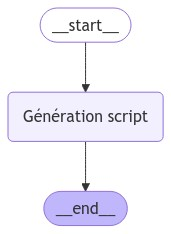

In [51]:
from IPython.display import Image, display

try:
    display(Image(wokflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [52]:
from langchain_core.messages import (
    HumanMessage,
)
from IPython.display import display, Markdown, Latex
query = "Generative AI current hype ?"
thread_id="05.03-notebookllm_podcast_clone"

transcript_response = await wokflow.ainvoke(
    {
        "query": query,
        "config": {
            "conversation_style": "natural", # engaging | fast-paced | enthusiastic
            "roles_person1": "main summarizer", 
            "roles_person2": "questioner/clarifier",
            "dialogue_structure": "Introduction", # Main Content Summary | Introduction | Conclusion
            "word_count": 2000,
            "podcast_name": "Podcast",
            "podcast_tagline": "Your Personal Generative AI Podcast",
            "engagement_techniques": "humor", # rhetorical questions |anecdotes | analogies | humor
            "output_language": "fr",
        }
    },
     {
        "callbacks": [langfuse_handler(thread_id)],
        "configurable": {"thread_id": thread_id}
    })
transcript_response

{'config': {'conversation_style': 'natural',
  'roles_person1': 'main summarizer',
  'roles_person2': 'questioner/clarifier',
  'dialogue_structure': 'Introduction',
  'word_count': 2000,
  'podcast_name': 'Podcast',
  'podcast_tagline': 'Your Personal Generative AI Podcast',
  'engagement_techniques': 'humor',
  'output_language': 'fr'},
 'query': 'Generative AI current hype ?',
 'transcript': {'transcript': '1. **Input Content Analysis**: The topic revolves around the current hype surrounding generative AI. Key points to discuss include the definition of generative AI, its applications, the reasons behind the hype, potential risks, and future implications. \n2. **Conversation Setup**: Person1 will summarize the main points about generative AI, while Person2 will ask clarifying questions and challenge some points. \n3. **Topic Exploration**: The conversation will cover what generative AI is, examples of its use, the excitement in the tech community, concerns about misuse, and predicti

In [ ]:

import openai
import os


def openai_tts(text: str, model: str, voice: str):
    response = openai.audio.speech.create(
        model=model,
        voice=voice,
        input=text
    )
    return response.content

def split_qa(self, input_text: str, ending_message: str, supported_tags: List[str] = None) -> List[Tuple[str, str]]:
        """
        Split the input text into question-answer pairs.

        Args:
            input_text (str): The input text containing Person1 and Person2 dialogues.
            ending_message (str): The ending message to add to the end of the input text.

        Returns:
                List[Tuple[str, str]]: A list of tuples containing (Person1, Person2) dialogues.
        """
        input_text = self.clean_tss_markup(input_text, supported_tags=supported_tags)
        # Add ending message to the end of input_text
        input_text += f"<Person2>{ending_message}</Person2>"

        # Regular expression pattern to match Person1 and Person2 dialogues
        pattern = r"<Person1>(.*?)</Person1>\s*<Person2>(.*?)</Person2>"

        # Find all matches in the input text
        matches = re.findall(pattern, input_text, re.DOTALL)

        # Process the matches to remove extra whitespace and newlines
        processed_matches = [
            (" ".join(person1.split()).strip(), " ".join(person2.split()).strip())
            for person1, person2 in matches
        ]
        return processed_matches


def _generate_audio_segments(text: str, temp_dir: str) -> List[str]:
    """Generate audio segments for each Q&A pair."""
    PROVIDER_SSML_TAGS: List[str] = ['break', 'emphasis']
    qa_pairs = split_qa(
        text, "Bye Bye!", PROVIDER_SSML_TAGS
    )
    audio_files = []
    question = "echo"
    answer = "shimmer"
    for idx, (question, answer) in enumerate(qa_pairs, 1):
        for speaker_type, content in [("question", question), ("answer", answer)]:
            temp_file = os.path.join(
                temp_dir, f"{idx}_{speaker_type}.mp3"
            )
            voice = "echo"
            if speaker_type == question: 
                 voice = answer

            audio_data = openai_tts(content, voice, model)
            with open(temp_file, "wb") as f:
                f.write(audio_data)
            audio_files.append(temp_file)

    return audio_files

from pydub import AudioSegment

def _merge_audio_files(self, audio_files: List[str], output_file: str) -> None:
    """
    Merge the provided audio files sequentially, ensuring questions come before answers.

    Args:
            audio_files: List of paths to audio files to merge
            output_file: Path to save the merged audio file
    """
    try:

        def get_sort_key(file_path: str) -> Tuple[int, int]:
            """
            Create sort key from filename that puts questions before answers.
            Example filenames: "1_question.mp3", "1_answer.mp3"
            """
            basename = os.path.basename(file_path)
            # Extract the index number and type (question/answer)
            idx = int(basename.split("_")[0])
            is_answer = basename.split("_")[1].startswith("answer")
            return (
                idx,
                1 if is_answer else 0,
            )  # Questions (0) come before answers (1)

        # Sort files by index and type (question/answer)
        audio_files.sort(key=get_sort_key)

        # Create empty audio segment
        combined = AudioSegment.empty()

        # Add each audio file to the combined segment
        for file_path in audio_files:
            combined += AudioSegment.from_file(file_path, format=self.audio_format)

        # Ensure output directory exists
        os.makedirs(os.path.dirname(output_file), exist_ok=True)

        # Export the combined audio
        combined.export(output_file, format=self.audio_format)
        print(f"Merged audio saved to {output_file}")

    except Exception as e:
        print(f"Error merging audio files: {str(e)}")
        raise

def convert_to_speech(self, text: str, output_file: str) -> None:
    """
    Convert input text to speech and save as an audio file.

    Args:
            text (str): Input text to convert to speech.
            output_file (str): Path to save the output audio file.

    Raises:
        ValueError: If the input text is not properly formatted
    """
    # Validate transcript format
    # self._validate_transcript_format(text)

    cleaned_text = text

    try:
        with output_dir:
            audio_segments = _generate_audio_segments(
                cleaned_text, output_dir
            )
            _merge_audio_files(audio_segments, output_file)
            print(f"Audio saved to {output_file}")


    except Exception as e:
        print(f"Error converting text to speech: {str(e)}")
        raise